<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/stock-predictions/blob/master/lab.ipynb">link</a>

First pipeline - data processing, including: one-hot encoding, adding time lags and so on

In [1]:
import pandas as pd

train = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
store = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store.csv')

def one_hot(dataframe, column):
    # use pd.concat to join the new columns with your original dataframe
    df = pd.concat([dataframe, pd.get_dummies(dataframe[column], prefix=column)], axis=1)
    # now drop the original column (you don't need it anymore)
    df.drop([column], axis=1, inplace=True)

    return df

def inner_join(df1, df2, column):
    return pd.concat([df1.set_index(column),df2.set_index(column)], axis=1, join='inner').reset_index()

def where_equal(df, column, value):
    return df[df[column] == value]

def lags(df, range, key):
    ds = df[key]
    df.drop([key], axis=1, inplace=True)
    stocks = 1115
    concatable = [df, ds.fillna(0)]
    for i in range:
        concatable.append(ds.shift(stocks * i).fillna(0).rename(f'{key}_{i}'))
    return pd.concat(concatable, axis=1)

def get_data():
    df = one_hot(train, 'DayOfWeek')

    df = inner_join(df, store, 'Store')
    df = one_hot(df, 'StoreType')
    df = one_hot(df, 'Assortment')
    df = one_hot(df, 'Store')
    df = lags(df, [1,2,3,4,5,6,7,8,9,10,11,12,13,14], 'Sales')

    df.drop([
        'StateHoliday',
        'SchoolHoliday',
        'Date',
        #'Customers',
        'Promo',
        'PromoInterval',
        'Promo2',
        'Promo2SinceWeek',
        'Promo2SinceYear',
        'CompetitionDistance',
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear'
    ], axis=1, inplace=True)

    # df = where_equal(df, 'Store', 1)
    # print(list(df))

    return df

get_data().head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Customers,Open,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,...,Store_1091,Store_1092,Store_1093,Store_1094,Store_1095,Store_1096,Store_1097,Store_1098,Store_1099,Store_1100,Store_1101,Store_1102,Store_1103,Store_1104,Store_1105,Store_1106,Store_1107,Store_1108,Store_1109,Store_1110,Store_1111,Store_1112,Store_1113,Store_1114,Store_1115,Sales,Sales_1,Sales_2,Sales_3,Sales_4,Sales_5,Sales_6,Sales_7,Sales_8,Sales_9,Sales_10,Sales_11,Sales_12,Sales_13,Sales_14
0,555,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,625,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,821,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1498,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,559,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we write our **classificator** for reducing incoming data dimensionality and grouping similar providers. We will use [AgglomerativeClustering](https://https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) for this purpose:

      Store  State_BE  State_BW  ...  Assortment_a  Assortment_b  Assortment_c
0         1         0         0  ...             1             0             0
1         2         0         0  ...             1             0             0
2         3         0         0  ...             1             0             0
3         4         1         0  ...             0             0             1
4         5         0         0  ...             1             0             0
...     ...       ...       ...  ...           ...           ...           ...
1110   1111         0         0  ...             1             0             0
1111   1112         0         0  ...             0             0             1
1112   1113         0         0  ...             0             0             1
1113   1114         0         0  ...             0             0             1
1114   1115         0         0  ...             0             0             1

[1115 rows x 20 columns]


AttributeError: ignored

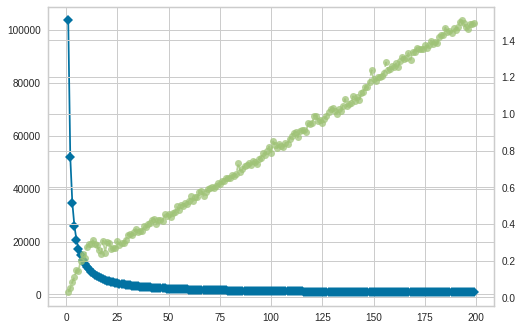

In [23]:
!pip install yellowbrick

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

import pandas as pd
import numpy as np

store_states = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store_states.csv')

def get_store_data():
    df = inner_join(store_states, store, 'Store')
    df = one_hot(df, 'State')
    df = one_hot(df, 'StoreType')
    df = one_hot(df, 'Assortment')

    df.drop([
            'PromoInterval',
            'Promo2',
            'Promo2SinceWeek',
            'Promo2SinceYear',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear'
        ], axis=1, inplace=True)
    
    return df

train_data = get_store_data()
# train_data.drop(['Store'], axis=1, inplace=True)

print(train_data)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,200))

visualizer.fit(train_data)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

Using TensorFlow backend.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1717)              1967682   
_________________________________________________________________
hidden_2 (Dense)             (None, 1145)              1967110   
_________________________________________________________________
hidden_3 (Dense)             (None, 572)               655512    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 573       
Total params: 4,590,877
Trainable params: 4,590,877
Non-trainable params: 0
_________________________________________________________________
None



Train on 762906 samples, validate on 254303 samples
Epoch 1/5





762906/762906 [==============================] - 609s 799us/step - loss: 1164764.1374 - acc: 0.0012 - val_loss: 859397.3005 - val_acc: 4.7581e-04
Epoch 2/5
762906/

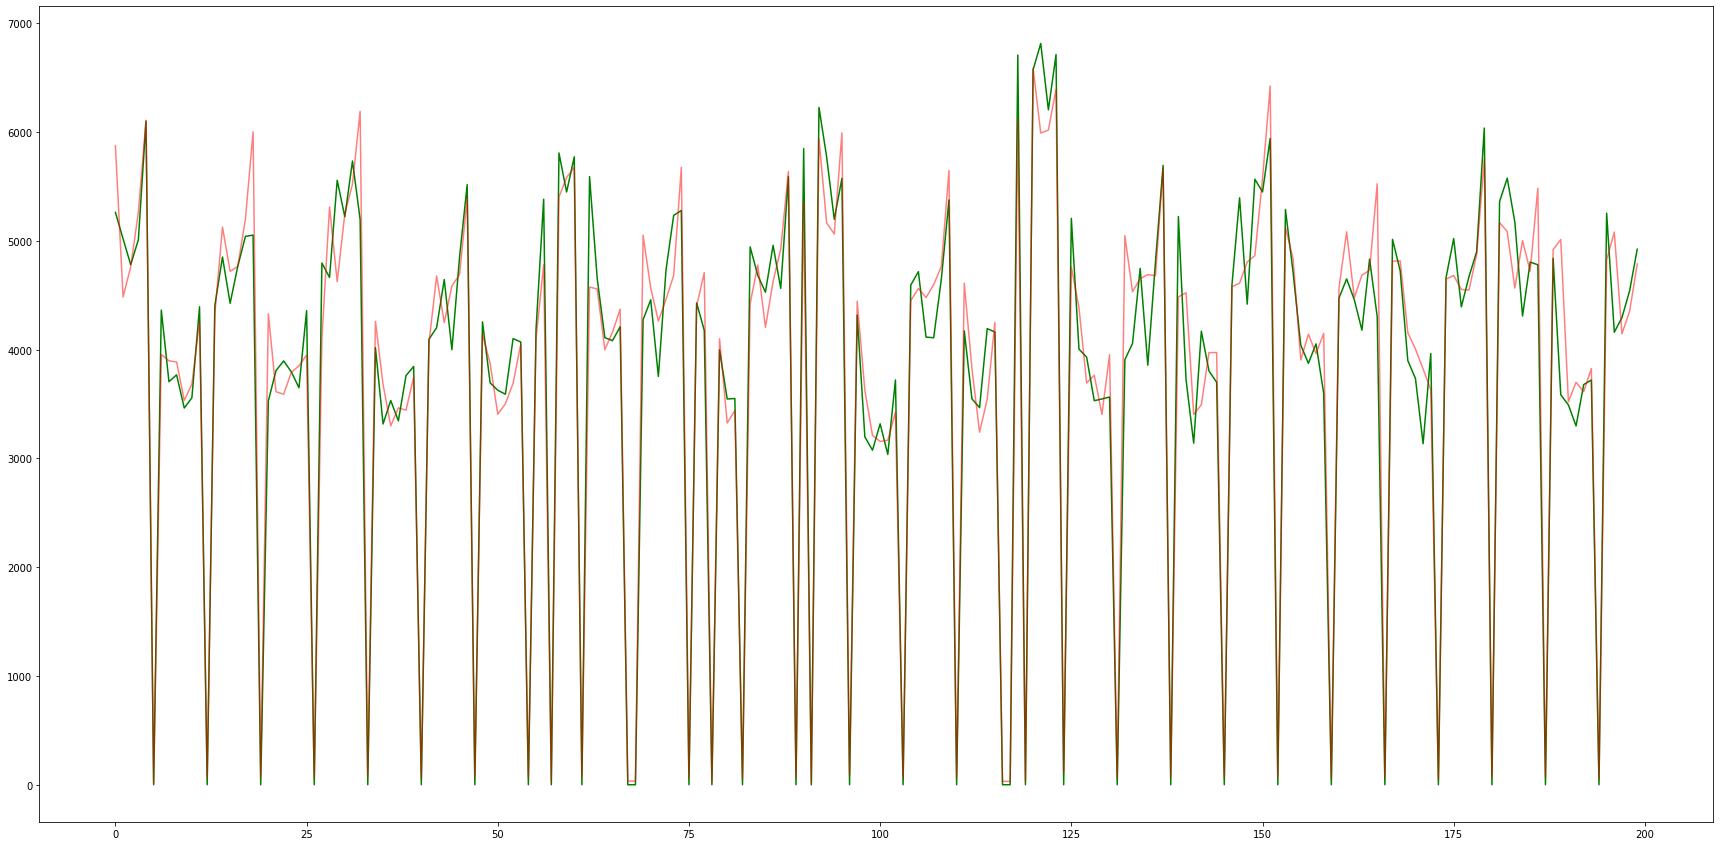

In [2]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

import tensorflow as tf

data = get_data()

y_vis = data[data['Store_1'] == 1]['Sales'][0:200]
# data = data[data['Store'] == 1]

y = data['Sales']
data.drop(['Sales'], axis=1, inplace=True)
X = data
X_vis = X[X['Store_1'] == 1][0:200]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

length, features = data.shape

model = Sequential()
model.add(Dense(int(features * 1.5), input_dim=features, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu', name='hidden_1'))
#model.add(Dropout(0.4, name='dropout_1'))
model.add(Dense(features, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_2'))
#model.add(Dropout(0.4, name='dropout_2'))
model.add(Dense(int(features * 0.5), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_3'))
#model.add(Dropout(0.5, name='dropout_3'))
model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), name='output_layer'))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.fit(X_train, y_train,
          epochs=5,
          validation_data=(X_test, y_test),
          verbose=1)

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

plt.plot(range(200), y_vis, color='green')
plt.plot(range(200), model.predict(X_vis).flatten(), color='red', alpha=0.5)
plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


942


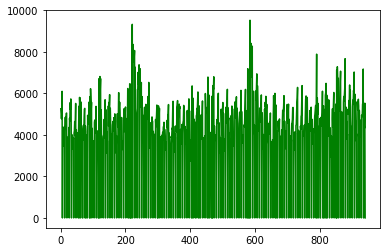

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
data = df[df['Store'] == 1]['Sales']

print(len(data))

plt.plot(range(942), data, color='green')
plt.show()